# LogisticRegression
虽然名字是回归，但是大多时间都用用来做分类。已知样本${x_i,y_i} \ \ i = 1,2,3,..,N$,模型函数定义如下   
$$z_i = \frac{1}{1+e^{-\theta x_i}}$$    
其中 $\theta$ 是模型参数
对于二分类问题，采用交叉熵损失函数    
$$
L = -\frac{1}{N}\sum_{i=1}^{N}[y_i log z_i + (1-y_i) log (1-z_i)]
$$
损失函数对参数求导   
$$
\frac{\partial L}{\partial \theta_j} = -\frac{1}{N}\sum_{i=1}^{N}[\frac{y_i}{z_i} \frac{\partial z_i}{\partial \theta_j} - \frac{1-y_i}{1-z_i} \frac{\partial z_i}{\partial \theta_j} ]
$$
其中   
$$
\frac{\partial z_i}{\partial \theta_j} = x_{ij} z_i (z_i - 1)
$$
带入得到
$$
\frac{\partial L}{\partial \theta_j} = -\frac{1}{N}\sum_{i=1}^{N}x_{ij}[z_i - y_i]
$$

In [1]:
import cv2
import sys,os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA


sample_size = (64//8,64//8)
smallset_size = 500 #每类下采样，方便调试
labels_in_use = set([1,0]) #二分类

num_pcs = 30 #

flag_debug = True

In [2]:
def load_mnist(num_per_class, dataset_root="C:/dataset/mnist/",resize=sample_size):
    data_pairs = []
    labeldict = {}
    ds_root = os.path.join(dataset_root,'train')
    for rdir, pdirs, names in os.walk(ds_root):
        for name in names:
            basename,ext = os.path.splitext(name)
            if ext != ".jpg":
                continue
            fullpath = os.path.join(rdir,name)
            label = fullpath.split('\\')[-2]
            label = int(label)
            if label not in labels_in_use:
                continue
            if num_per_class > 0 and ( label in labeldict.keys() ) and labeldict[label] >= num_per_class:
                continue
            data_pairs.append((label,fullpath))
            if label in labeldict:
                labeldict[label] += 1
            else:
                labeldict[label] = 1
    data = np.zeros((resize[0]*resize[1],len(data_pairs)))
    labels = np.zeros(len(data_pairs))
    for col,(label, path) in enumerate(data_pairs):
        img = cv2.imread(path,0)
        img = cv2.resize(img,resize)
        img = (img / 255.0).flatten()
        data[:,col] = img
        labels[col] = label
    return (data,labels)

X,Y = load_mnist(smallset_size)

#if num_pcs > 0:
#    pca = PCA(num_pcs)
#    X = pca.fit_transform(X)


In [3]:
def update_theta(theta, dtheta, lr):
    theta -= lr * dtheta
    return theta

def calc_logistic_regression(X,theta):
    theta_tile = np.tile( np.reshape(theta,(-1,1)), (1, X.shape[1])   )
    val = (theta_tile * X).sum(axis=0)
    scores = np.reshape( 1 / (1 + np.exp(-val)), X.shape[1])
    return scores

def calc_loss(X,Y,theta,eps = 0.000):
    Z = calc_logistic_regression(X,theta)
    lgZ, log1sZ = np.log(Z+eps), np.log(1-Z+eps)
    loss = -(Y * lgZ + (1-Y)*log1sZ).mean()
    return loss
    
    

def calc_gradient(X,Y,theta):
    N = len(Y)
    Z = calc_logistic_regression(X,theta)
    A = np.reshape(Z-Y, (1,-1))
    grad = (X * np.tile(A, (X.shape[0],1))).mean(axis=1)
    return grad

def predict(X,theta,th = 0.5):
    Z = calc_logistic_regression(X,theta)
    Ybar = Z >= th
    return Ybar.astype(int)    


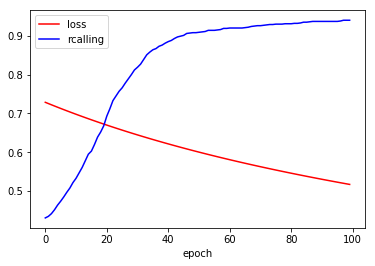

In [4]:
lr = 0.01
theta = np.random.normal(0,0.1,X.shape[0])
loss_rec, recall_rec = [], []
for epoch in range(100):
    grad = calc_gradient(X,Y,theta)
    theta = update_theta(theta,grad,lr)
    Ybar = predict(X,theta)
    hit = (Ybar == Y).sum()
    loss = calc_loss(X,Y,theta)
    loss_rec.append(loss)
    recall_rec.append(hit/X.shape[1])
    #print('epoch {} recalling {} loss {}'.format(epoch,hit / X.shape[1],loss))

    
plt.plot(range(len(loss_rec)), loss_rec, color='red', label='loss')
plt.plot(range(len(recall_rec)), recall_rec, color='blue',label='rcalling')
plt.legend()
plt.xlabel("epoch")
plt.show()